<a href="https://colab.research.google.com/github/pachterlab/GVFP_2021/blob/main/gg220316_sim_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Simulation code for "Interpretable and tractable models of transcriptional noise for the rational design of single-molecule quantification experiments"</center></h1>

# Outline
This notebook demonstrates the simulation procedure for the $\Gamma$-OU and CIR transcription rate variation models, coupled to a two-step transcription -- splicing -- degradation process. 

The $\Gamma$-OU simulation is exact and uses MATLAB code called through an Octave wrapper (`oct2py`). The CIR simulation is approximate and uses all native Python functions.

# Download data
First, we need to download the code from the Github repository.


In [1]:
import time  as ti
start_time = ti.time()


In [2]:
!git clone https://github.com/pachterlab/GVFP_2021.git

Cloning into 'GVFP_2021'...
remote: Enumerating objects: 459, done.
remote: Counting objects: 100% (459/459), done.
remote: Compressing objects: 100% (368/368), done.
remote: Total 459 (delta 203), reused 274 (delta 83), pack-reused 0
Receiving objects: 100% (459/459), 119.89 MiB | 37.00 MiB/s, done.
Resolving deltas: 100% (203/203), done.


In [3]:
!mv GVFP_2021/data/* .
!mv GVFP_2021/functions/* .

# Import dependencies.


In [4]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import sys

import scipy 
import scipy.io as sio
import scipy.integrate

from scipy.stats import poisson, nbinom


# import pickle
%config InlineBackend.figure_format = 'retina'

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# %%capture 
# !pip install parfor

In [7]:
# from parfor import parfor

In [8]:
from autocorr_functions import *
from CIR_functions import *
from GOU_functions import *
from CIR_Gillespie_functions import *
from numpy.fft import ifft

In [9]:
    #a e s t h e t i c s

#https://github.com/EdwinTh/dutchmasters this is girl with pearl earring
vermeer_hex = ("#A65141", "#E7CDC2", "#80A0C7", "#394165", "#FCF9F0", "#B1934A",
             "#DCA258", "#100F14", "#8B9DAF", "#EEDA9D")
#https://stackoverflow.com/questions/29643352/converting-hex-to-rgb-value-in-python
vermeer = [(tuple(int(h.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))) for h in vermeer_hex] 


#this is the Vermeer milkmaid color palette
vermeer_milk_hex = ("#48211A", "#376597", "#537270", "#556246", "#928F6B", "#CCAF69",
             "#ECE5D3", "#104A8A", "#C5AC8E", "#889F95", "#7C4728", "#00295D", "#D9B196")
vermeer_milk = [(tuple(int(h.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))) for h in vermeer_milk_hex] 

w_mean = 2
w_one = 0.5
w_comp = 1.5
col_mean = [0,0,0]
col_one = [0.5]*3
col_hist = [0.7]*3
scatter_col = [0.2]*3
scatter_size = 1
scatter_alpha = 0.3
col_theory = [1,0,0]
w_theory = 1.5
fontsize = 12
fontsize_big=16
col_limiting = vermeer[3]
col_compare = vermeer[0]
col_ouig = vermeer[5]

In [10]:
!mkdir -p fig

# Octave installation

In [11]:
%%capture
!sudo apt-get install octave
!sudo apt-get install -y liboctave-dev

In [12]:
%%capture
!pip install oct2py

In [13]:
%%capture
import oct2py
from oct2py import octave
oc = oct2py.Oct2Py()
oc.eval('pkg install -forge specfun')
oc.addpath('.')
oc.eval('pkg load specfun')


## Stationary distributions 

In [14]:
labels_y = ('Transcription rate','Probability','Probability','Mature counts + 1')
labels_x = ('Time','Nascent counts','Mature counts','Nascent counts + 1')

# $\Gamma$-OU simulation

Here, we define the custom code that calls the MATLAB simulation function and outputs at `mat` file with simulation results.

In [15]:
def Gillespie_GOU_2D_data(beta,gamma,kappa,alpha,eta,T,lag,nCell,filename,T_=5,nT1=500,nT2=100):
    
    L = alpha*kappa
    splic = beta
    S = np.asarray(([[1, 0], [-1, 1], [0, -1], [0, 0]]))
    sde_params = np.array([kappa,L,eta])
    if T==None:
        Tscale = 1/min([kappa,gamma,L,splic])
        T = T_*Tscale

    tvec_mol = np.linspace(0,T,nT1)
    te = T+lag
    tvec_sde = np.linspace(T,te,nT2)
    tvec = np.concatenate((tvec_mol[:-1],tvec_sde))
    t_matrix = np.matlib.repmat(tvec,nCell,1)

    kpar = np.array([np.nan,splic,gamma])

    SDE = np.array([kappa,L,eta])
    
    t1 = ti.time()
    Y = oc.gg_210207_gillespie_gou_oct_1(kpar,t_matrix,S,nCell,SDE)[:,:,:3]
    trun = ti.time()-t1
    X_s = np.squeeze(Y[:,(nT1-1):,:2])
    SDE_t = np.squeeze(Y[:100,:nT1,2])
    SDE_mean = np.squeeze(np.mean(Y[:,:nT1,2],0))
    SDE_ss = np.squeeze(Y[:,nT1,2])

    meta = ('alpha, eta: shape and rate parameters of gamma distribution\t' + 'beta, gamma: splicing and degradation rate\n' 
            + 'kappa: mean-reversion rate\t' + 'T: simulation timescale end. Tmax = T/min([kappa, gamma, alpha*kappa, eta])\n' 
            + 'nCell: Number of cells\t' + 'trun: Runtime (seconds)\n'
            + 'nT: number of time points\t' + 'Tmax: End time\t' + 'tvec_sde: Time vector of SDE\n' 
            + 'X_s: 2D array of molecule counts in each cell at Tmax (nCell, 2)\n'
            + 'SDE_t: 100 samples of simulated CIR process (100, nT)\t' + 'SDE_mean: mean of all CIR processes (not SDE_t)')
    # SDE_mean = np.mean(SDE, axis = 0)            
    mdict={'runtime': trun, 'Ncell': nCell, 'Tmax': te, 'T': T, 'tvec_mol': tvec_mol, 'tvec_sde': tvec_sde,
            'X_s': np.array(X_s), 'SDE_t': SDE_t, 'SDE_mean': SDE_mean,
            'alpha': alpha, 'eta': eta, 'kappa': kappa, 'beta': splic, 'gamma': gamma, 'SDE_ss': SDE_ss,
            'metadata': meta}
    sio.savemat(filename, mdict, do_compression = True)


Here, we define the parameter values. These are close to the "maximally divergent" parameters described in the manuscript.

In [16]:
kappa,L,eta,beta,gamma = 1, 0.25, 0.1, 2.5, 0.2
alpha = L/kappa
T = 25
lag = 10
nCell = 1000

Simulate the system.

In [17]:
Gillespie_GOU_2D_data(beta,gamma,kappa,L/kappa,eta,T,lag,nCell,'gou_{}.mat'.format('8_sample'),nT1=500,nT2=100)

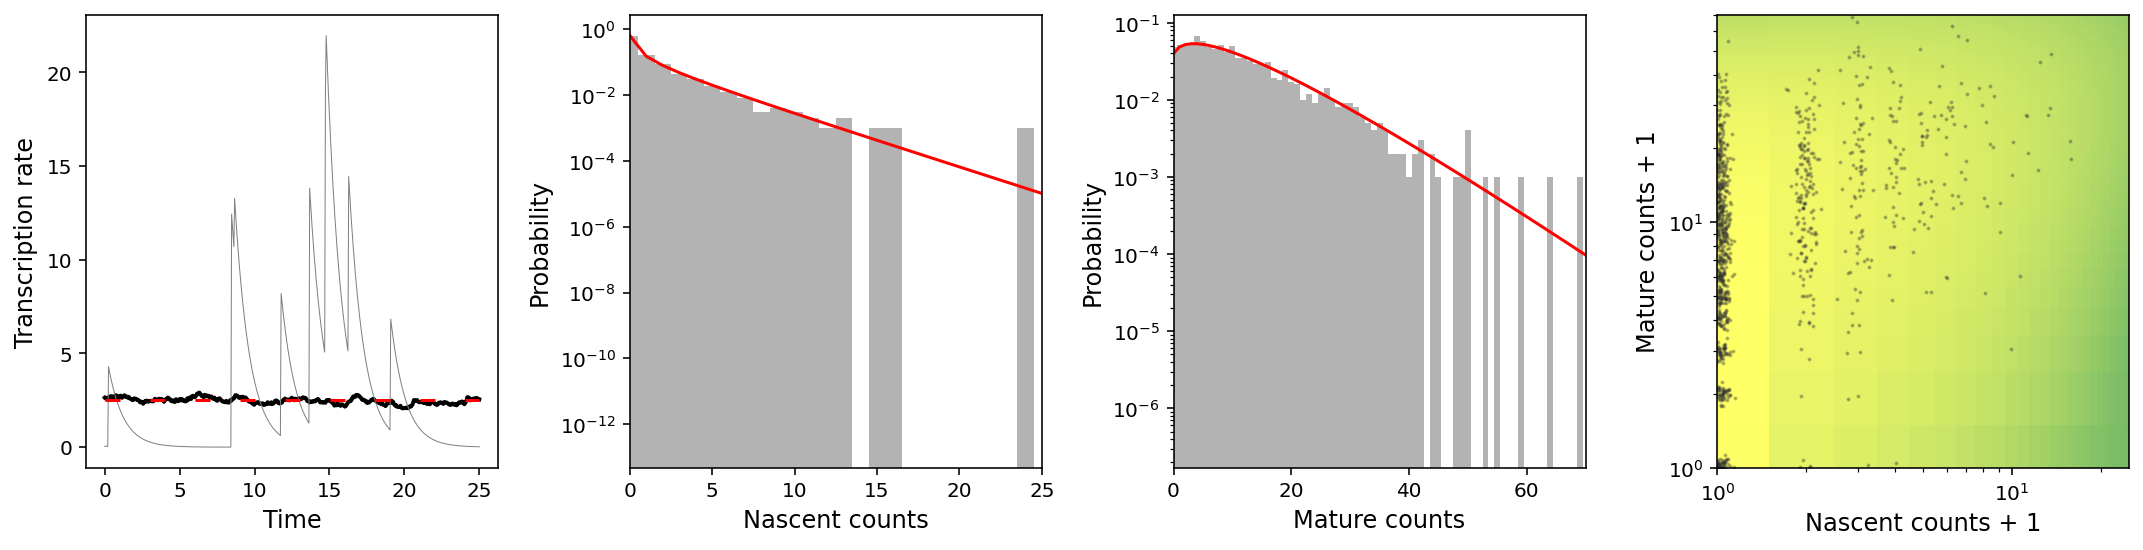

In [18]:
N=1
names = ['gou_8_sample.mat']
sz = (N,4)
figsize = (15,4)
fig1,ax1=plt.subplots(nrows=sz[0],ncols=sz[1],figsize=figsize)
splic_name = 'beta'

IND_ = [18]

# for k_ in range(3,4):
for k_ in range(N):
    F = sio.loadmat(names[k_])
    kappa = F['kappa'][0,0]
    alpha = F['alpha'][0][0]
    L = alpha*kappa
    eta = F['eta'][0,0]
    splic = F[splic_name][0][0]
    gamma = F['gamma'][0][0]


    X_s = F['X_s'][:,0,:].astype('int')
    tvec = F['tvec_mol'][0]
    T_ss = np.inf
    offs = 50

    x_nas = np.arange(np.amax(X_s[:,0])+offs)
    x_mat = np.arange(np.amax(X_s[:,1])+offs)
    Pss = np.squeeze(cme_integrator(L,1/eta/kappa,gamma,[kappa,splic],[1,x_nas[-1]+1,x_mat[-1]+1],T_ss))


    ###
    ax1[0].plot(tvec,np.squeeze(F['SDE_mean']),color=col_mean,linewidth=w_mean)
    ax1[0].plot(tvec,F['SDE_t'][IND_[k_],:],color=col_one,linewidth=w_one)
    ax1[0].plot([0,tvec[-1]],[alpha/eta]*2,color=col_theory,linestyle=(0,(5,10)),linewidth=w_theory)

    ###NASCENT
    bins_ = x_nas-0.5
    ax1[1].hist(X_s[:,0],bins=bins_, density=True,color=col_hist)

    y = np.sum(Pss,1)
    y = np.squeeze(y)[0:len(x_nas)]
    ax1[1].plot(x_nas,y,linewidth=w_theory,color=col_theory)
    ax1[1].set_yscale('log')
    ax1[1].set_xlim([0,np.amax(X_s[:,0])+1])
    
    ###
    bins_ = x_mat-0.5
    ax1[2].hist(X_s[:,1],bins=bins_, density=True,color=col_hist)

    y = np.sum(Pss,0)
    y = np.squeeze(y)[0:len(x_mat)]
    ax1[2].plot(x_mat,y,linewidth=w_theory,color=col_theory)
    ax1[2].set_yscale('log')
    ax1[2].set_xlim([0,np.amax(X_s[:,1])+1])
    

    ###
    nCells = X_s.shape[0]
    noise = 1+np.random.randn(nCells,2)/20

    nas_ = (X_s[:,0]+1)*noise[:,0]
    filt = np.logical_and(X_s[:,0]==0, nas_<1)
    nas_[filt] = 2-nas_[filt]

    mat_ = (X_s[:,1]+1)*noise[:,1]
    filt = np.logical_and(X_s[:,1]==0, mat_<1)
    mat_[filt] = 2-mat_[filt]


    Pa = np.log10(np.squeeze(Pss)[0:len(x_nas),0:len(x_mat)])
    X_,Y_ = np.meshgrid(x_nas+0.5,x_mat+0.5)
    ax1[3].pcolor(X_.T,Y_.T,Pa,cmap='summer')    
    ax1[3].scatter(nas_,mat_,color=scatter_col,s=scatter_size,alpha=scatter_alpha,edgecolors=None)
    ax1[3].set_xscale('log')
    ax1[3].set_yscale('log')
    ax1[3].set_xlim([1,np.amax(X_s[:,0])+1])
    ax1[3].set_ylim([1,np.amax(X_s[:,1])+1])

# ax1[0].
for j_ in range(4):
    ax1[j_].set_ylabel(labels_y[j_],fontsize=fontsize)
for j_ in range(4):
    ax1[j_].set_xlabel(labels_x[j_],fontsize=fontsize)

fig1.tight_layout()
plt.savefig('fig/gou_sample.png',dpi=450)
plt.savefig('fig/gou_sample.pdf')

# CIR simulation

Here, we simulate the CIR model using the same parameter values.

In [19]:

n_threads = 2
trun=Gillespie_CIR_2D_data(beta, gamma, kappa, alpha, eta, T, lag, nCell, n_threads, filename='CIR_8_sample.mat')
# print(trun)

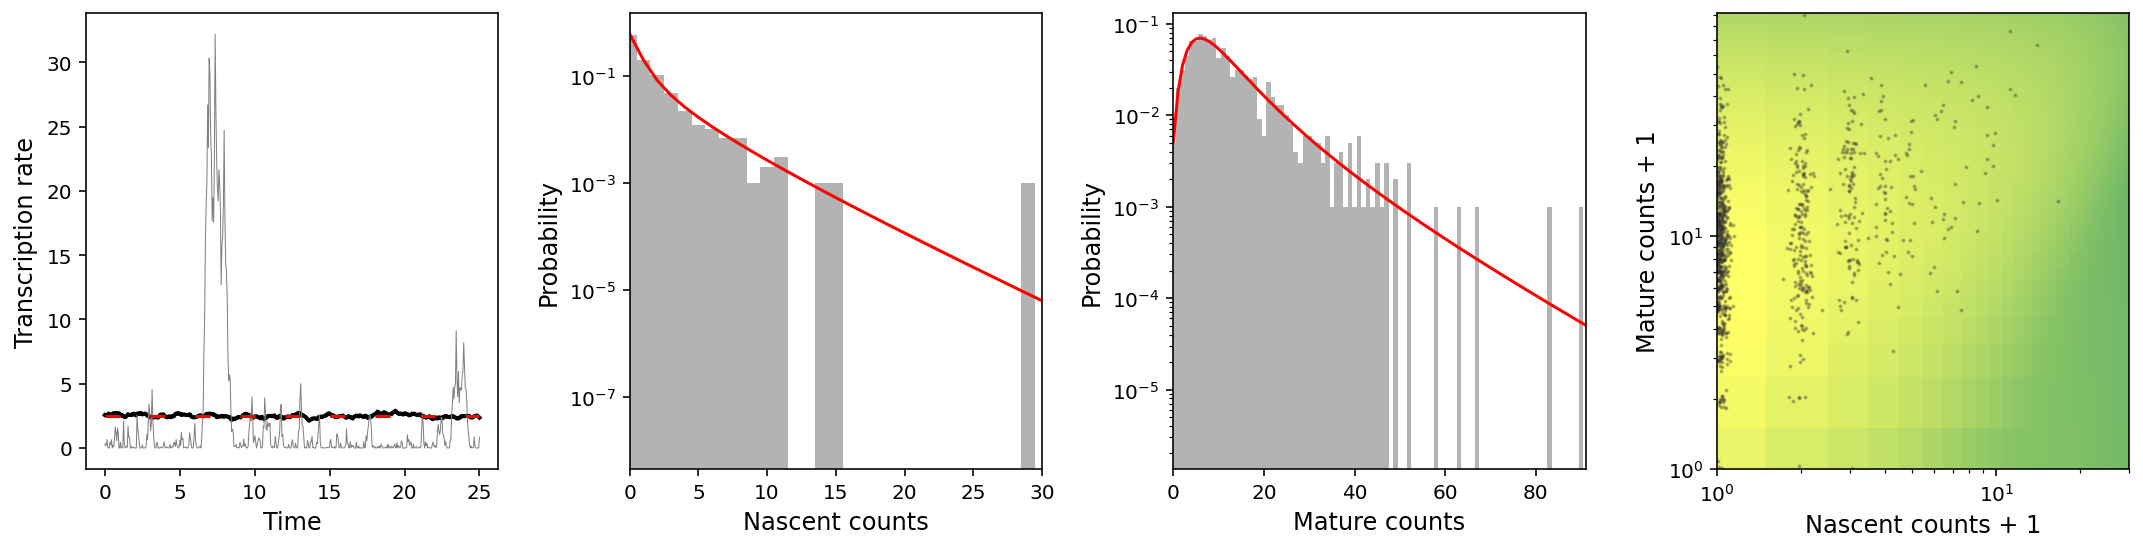

In [20]:
N=1
names = ['CIR_8_sample.mat']
sz = (N,4)
figsize = (15,4)
fig1,ax1=plt.subplots(nrows=sz[0],ncols=sz[1],figsize=figsize)


IND_ = [18,6,4,1,23,12]

# for k_ in range(3,4):
for k_ in range(N):
    F = sio.loadmat(names[k_])
    kappa = F['kappa'][0,0]
    alpha = F['alpha'][0][0]
    L = alpha*kappa
    eta = F['eta'][0,0]
    splic = F[splic_name][0][0]
    gamma = F['gamma'][0][0]


    X_s = F['X_s'][:,0,:].astype('int')
    tvec = F['tvec_sde'][0]
    T_ss = np.inf
    offs = 50

    x_nas = np.arange(np.amax(X_s[:,0])+offs)
    x_mat = np.arange(np.amax(X_s[:,1])+offs)
    Pss = np.squeeze(get_Pss_CIR_2sp_ODE([x_nas[-1]+1,x_mat[-1]+1], [splic,gamma,kappa,1/eta,alpha]))


    ###
    ax1[0].plot(tvec,np.squeeze(F['SDE_mean']),color=col_mean,linewidth=w_mean)
    ax1[0].plot(tvec,F['SDE_t'][IND_[k_],:],color=col_one,linewidth=w_one)
    ax1[0].plot([0,tvec[-1]],[alpha/eta]*2,color=col_theory,linestyle=(0,(5,10)),linewidth=w_theory)

    ###NASCENT
    bins_ = x_nas-0.5
    ax1[1].hist(X_s[:,0],bins=bins_, density=True,color=col_hist)

    y = np.sum(Pss,1)
    y = np.squeeze(y)[0:len(x_nas)]
    ax1[1].plot(x_nas,y,linewidth=w_theory,color=col_theory)
    ax1[1].set_yscale('log')
    ax1[1].set_xlim([0,np.amax(X_s[:,0])+1])
    
    ###
    bins_ = x_mat-0.5
    ax1[2].hist(X_s[:,1],bins=bins_, density=True,color=col_hist)

    y = np.sum(Pss,0)
    y = np.squeeze(y)[0:len(x_mat)]
    ax1[2].plot(x_mat,y,linewidth=w_theory,color=col_theory)
    ax1[2].set_yscale('log')
    ax1[2].set_xlim([0,np.amax(X_s[:,1])+1])
    

    ###
    nCells = X_s.shape[0]
    noise = 1+np.random.randn(nCells,2)/20

    nas_ = (X_s[:,0]+1)*noise[:,0]
    filt = np.logical_and(X_s[:,0]==0, nas_<1)
    nas_[filt] = 2-nas_[filt]

    mat_ = (X_s[:,1]+1)*noise[:,1]
    filt = np.logical_and(X_s[:,1]==0, mat_<1)
    mat_[filt] = 2-mat_[filt]


    Pa = np.log10(np.squeeze(Pss)[0:len(x_nas),0:len(x_mat)])
    X_,Y_ = np.meshgrid(x_nas+0.5,x_mat+0.5)
    ax1[3].pcolor(X_.T,Y_.T,Pa,cmap='summer')    
    ax1[3].scatter(nas_,mat_,color=scatter_col,s=scatter_size,alpha=scatter_alpha,edgecolors=None)
    ax1[3].set_xscale('log')
    ax1[3].set_yscale('log')
    ax1[3].set_xlim([1,np.amax(X_s[:,0])+1])
    ax1[3].set_ylim([1,np.amax(X_s[:,1])+1])

# ax1[0].
for j_ in range(4):
    ax1[j_].set_ylabel(labels_y[j_],fontsize=fontsize)
for j_ in range(4):
    ax1[j_].set_xlabel(labels_x[j_],fontsize=fontsize)

fig1.tight_layout()
plt.savefig('fig/cir_sample.png',dpi=450)
plt.savefig('fig/cir_sample.pdf')

In [21]:
tend = ti.time()
print(tend-start_time)

420.0213096141815
